In [8]:
# !pip install lime
# !pip install opencv-python-headless
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.1/571.1 KB 19.2 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


### LIME Image Explainer

2022-04-05 00:47:34.811754: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


49152/35363 [=========================================] - 0s 0us/step
('n02123045', 'tabby', 0.48081297)
('n02123159', 'tiger_cat', 0.43827268)
('n02124075', 'Egyptian_cat', 0.043701846)
('n03794056', 'mousetrap', 0.0032283608)
('n03793489', 'mouse', 0.002255249)


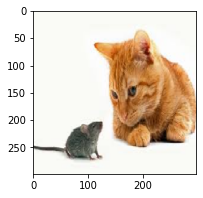

In [6]:
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import lime
from lime import lime_image
import skimage
import cv2

def load_img(path,input_size):
    img = image.load_img(path, target_size=(input_size, input_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def predict_class(img):
    img = inc_net.preprocess_input(img)
    img = np.vstack([img])
    return inet_model.predict(img)

inet_model = inc_net.InceptionV3()

img = load_img('cat-and-mouse.jpeg',299)
preds = predict_class(img)
plt.figure(figsize=(3,3))
plt.imshow(img[0] / 2 + 0.5)
for x in decode_predictions(preds)[0]:
    print(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

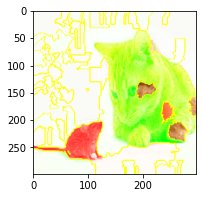

In [7]:
# instantiate lime image explainer and get the explaination 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

# plot interpretation
temp, mask = explanation.get_image_and_mask(282, positive_only=False, num_features=100, hide_rest=False)
plt.figure(figsize=(3,3))
plt.imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask))

### SHAP Partition Explainer

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import json 

# load pretrained model
model = ResNet50(weights='imagenet')
def predict(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# get imagenet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
    
# load and batch the image
img = load_img('cat-and-mouse.jpeg',224)
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", img.shape[1:])

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker, output_names=class_names,algorithm='partition')

# here we explain the same image and use 1000 evaluations of Resnet50 to get the shap values 
shap_values = explainer(img, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

2022-04-05 00:48:33.884864: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30105600 exceeds 10% of free system memory.
2022-04-05 00:48:35.168082: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30105600 exceeds 10% of free system memory.
2022-04-05 00:48:36.175611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30105600 exceeds 10% of free system memory.


  0%|          | 0/498 [00:00<?, ?it/s]

2022-04-05 00:48:39.215261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30105600 exceeds 10% of free system memory.
2022-04-05 00:48:40.244430: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30105600 exceeds 10% of free system memory.
Partition explainer: 2it [00:15, 15.42s/it]               


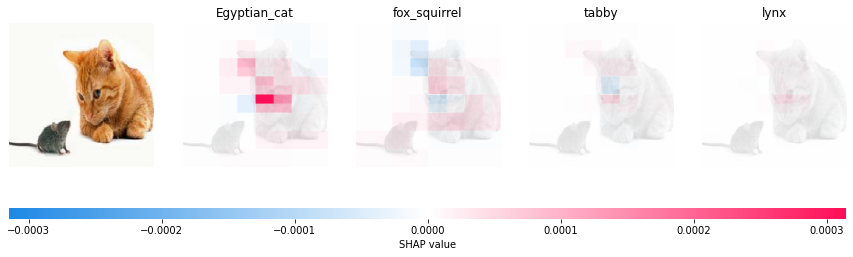

In [11]:
shap.image_plot(shap_values)

### Grad CAM

In [12]:
import tensorflow as tf
import keras
import matplotlib.cm as cm
from IPython.display import Image

def make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER_NAME, pred_index=None):
    # Step 1
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(LAST_CONV_LAYER_NAME).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Step 2
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Step 3
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Step 4
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Step 5
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [14]:
# Prepare image
img_array = preprocess_input(load_img('cars.jpeg',224))
# Print the top 2 predicted classes
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

Predicted: [('n04285008', 'sports_car', 0.67982984), ('n04037443', 'racer', 0.18915515)]


In [15]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    # Display the image
    plt.figure(figsize=(8,4))
    plt.axis("off")
    plt.imshow(superimposed_img)


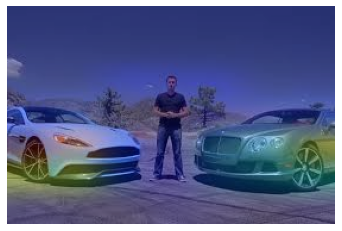

In [17]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block3_out', pred_index=class_names.index("sports_car"))
save_and_display_gradcam('cars.jpeg', heatmap)

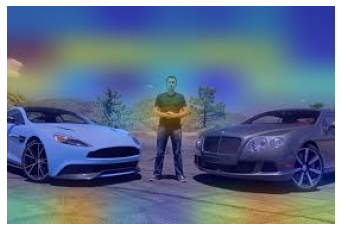

In [18]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block3_out', pred_index=class_names.index("racer"))
save_and_display_gradcam('cars.jpeg', heatmap)

### Guided Grad CAM

In [19]:
@tf.custom_gradient
def guided_relu(x):
    # guided version of relu which lets back only postive gradients in backpropogation
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        # build a guided version of the model replace ReLU with guided ReLU
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray, class_index: int):
        # convert to one hot representation to match our softmax activation in the model definition
        expected_output = tf.one_hot([class_index] * image.shape[0], NUM_CLASSES)
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
            loss = tf.keras.losses.categorical_crossentropy(
                expected_output, outputs
            )
        # get the gradient of the loss with respect to the input image
        grads = tape.gradient(loss, inputs)[0]
        return grads

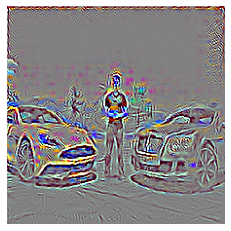

In [20]:
gb = GuidedBackprop(model)
NUM_CLASSES = 1000
saliency_map = gb.guided_backprop(img_array, class_index=class_names.index("sports_car")).numpy()

# Normalize with mean 0 and std 1
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
# Change mean to 0.5 and std to 0.25
saliency_map *= 0.25
saliency_map += 0.5
# Clip values between 0 and 1
saliency_map = np.clip(saliency_map, 0, 1)
# Change values between 0 and 255
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

plt.axis('off')
plt.imshow(saliency_map)

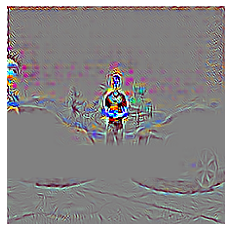

In [21]:
gb = GuidedBackprop(model)

# Guided grad_cam is just guided backpropogation with feature importance coming from grad-cam
saliency_map = gb.guided_backprop(img_array, class_index=class_names.index("sports_car")).numpy()
gradcam = cv2.resize(heatmap, (224, 224))
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
guided_gradcam = saliency_map * np.repeat(gradcam[..., np.newaxis], 3, axis=2)

# Normalize
guided_gradcam -= guided_gradcam.mean()
guided_gradcam /= guided_gradcam.std() + tf.keras.backend.epsilon()
guided_gradcam *= 0.25
guided_gradcam += 0.5
guided_gradcam = np.clip(guided_gradcam, 0, 1)
guided_gradcam *= (2 ** 8) - 1
guided_gradcam = guided_gradcam.astype(np.uint8)

plt.axis('off')
plt.imshow(guided_gradcam)

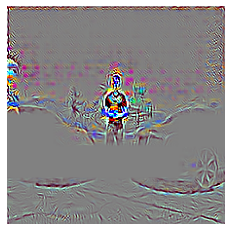

In [22]:
gb = GuidedBackprop(model)

# Guided grad_cam is just guided backpropogation with feature importance coming from grad-cam
saliency_map = gb.guided_backprop(img_array, class_index=class_names.index("racer")).numpy()
gradcam = cv2.resize(heatmap, (224, 224))
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
guided_gradcam = saliency_map * np.repeat(gradcam[..., np.newaxis], 3, axis=2)

# Normalize
guided_gradcam -= guided_gradcam.mean()
guided_gradcam /= guided_gradcam.std() + tf.keras.backend.epsilon()
guided_gradcam *= 0.25
guided_gradcam += 0.5
guided_gradcam = np.clip(guided_gradcam, 0, 1)
guided_gradcam *= (2 ** 8) - 1
guided_gradcam = guided_gradcam.astype(np.uint8)

plt.axis('off')
plt.imshow(guided_gradcam)

### Expected Gradients

2022-04-05 00:50:32.295391: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


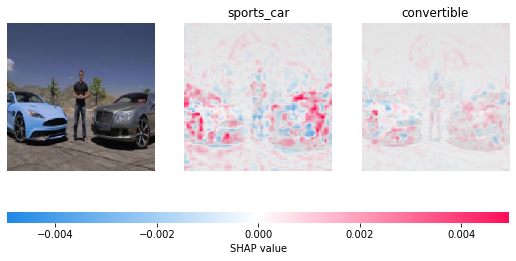

In [24]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = load_img('cars.jpeg',224)

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)
    
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7) ,local_smoothing=100)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)
